<a href="https://colab.research.google.com/github/JoseMa39/adgCardexHotels/blob/main/cardexExploratoryByDate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración googleDrive


In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from google.colab import data_table

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine.data import mtcars

pd.options.display.float_format = '{:.2f}'.format

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
paths = ["./drive/MyDrive/adgTravel/upselling/cardex.csv", "./drive/MyDrive/adgTravel/upselling/pwcJune.csv"]

# Cargando Dataframes

In [4]:
def loadDfs(paths):
  dfArray = []
  for path in paths:
    dfArray.append(pd.read_csv(path))
  return dfArray

In [5]:
def joinDF(dfArray):
  if (len(dfArray))< 1:
    raise Exception("Sorry, at least one df is required")
  
  dfResult = dfArray[0]
  for index in range(1,len(dfArray)):
    dfResult = dfResult.append(dfArray[index])
  dfResult = dfResult.reset_index()
  return dfResult.drop_duplicates(subset=['Clave','Documento', 'Nombre', 'Apellido1', 'Venta', 'Entrada', 'Salida', 'Reserva', "Linea", "Numero"], keep='last')
    

In [6]:
def loadIntoOneDf(dfArray):
  return joinDF(dfArray)

# Clasificando datos

In [7]:
def classifyingDF(df:pd.DataFrame):
  df["ID_HASH"] = df["Documento"].fillna("") + df["Nombre"].fillna("") + df["Apellido1"].fillna("")
  df["ID_HASH"] = df["ID_HASH"].apply(hash)
  return df

def dropPersonalDataColumns(df):
  df = df.drop(['Clave', 'TipoDocumento', 'Documento', 'Nombre', "Apellido1", "Apellido2"], axis = 1)
  return df

def classifiedData(df:pd.DataFrame):
  return dropPersonalDataColumns(classifyingDF(df))

# Columna Sexo

In [8]:
def sexAsCategorical(df:pd.DataFrame):
  df["Sexo"] = pd.Categorical(df["Sexo"])
  return df

# Columna Nacionalidad

In [9]:
def fixNacionalities(df:pd.DataFrame):
  df["PaisResidencia"] = df["PaisResidencia"].fillna(df["Nacionalidad"])
  df.loc[df['PaisResidencia']=="VARIOS","PaisResidencia"] = df["Nacionalidad"]
  df.loc[df['PaisResidencia'] == 'SCG','PaisResidencia'] = 'SRB'
  df["PaisResidencia"] = pd.Categorical(df["PaisResidencia"])
  df = df.dropna(subset=["PaisResidencia"])
  return df

In [10]:
def dropNacionalitiesColumns(df):
  df = df.drop(['Nacionalidad', 'CodigoPostal', 'Localizador', "Tarifa"], axis = 1)
  return df

## Recodificando pais por regiones

In [11]:
def unifiedNacionalities(df:pd.DataFrame, infLimit = 200):
  countryCodesDf = pd.read_csv("./drive/MyDrive/adgTravel/upselling/countriesByRegion.csv", usecols=['alpha-3', 'sub-region', 'intermediate-region'], index_col=['alpha-3'])

  countryCodesIsNullDf = countryCodesDf.isnull()
  dfGroupByCountry = df['PaisResidencia'].value_counts()

  def fillCountryWithRegion(row):
    if(dfGroupByCountry[row]>infLimit or row == "VARIOS"):
      return row
    if(not countryCodesIsNullDf.loc[row]['intermediate-region']):
      return countryCodesDf.loc[row]['intermediate-region']
    return countryCodesDf.loc[row]['sub-region']
  
  df["PaisResidencia"] = df["PaisResidencia"].apply(fillCountryWithRegion)
  return df

In [12]:
def fixNacionalitiesAndDropColumns(df:pd.DataFrame):
  return unifiedNacionalities(dropNacionalitiesColumns(fixNacionalities(df)))

# Columna Fecha de Nacimiento

In [13]:
def fixingBirthDates(date):
  if((not isinstance(date, str)) or date=="NaN" or date=="nan"):
    return date
  dateSplitted = date.split("/")
  year = int(dateSplitted[2])
  if year < 1900:
    year += 100 * ((2000 - year)//100)
  return f"{dateSplitted[0]}/{dateSplitted[1]}/{year}"

def fixingBirthday(df: pd.DataFrame):
  df["FechaNacimiento"] = df["FechaNacimiento"].apply(fixingBirthDates)
  return df



# EDAD

In [14]:
def calculateAge(row):
  birthYear = int(row['FechaNacimiento'].split('/')[2])
  bookYear = int(row['Venta'].split('/')[2])
  return bookYear - birthYear

def getAgeRange(row):
  if(row.isnull().any()):
    return "NaN"
  return calculateAge(row)
  
def calculateAgeDf(df:pd.DataFrame):
  df["Edad"] = df[["FechaNacimiento", "Venta"]].apply(getAgeRange, axis=1)
  df["Edad"] = pd.to_numeric(df["Edad"], errors="coerce", downcast="signed")
  return df

#columna de cant de dias de la reserva

In [15]:
from datetime import date
import time

def amountOfDays(startDate, endDate):
  startDate = startDate.split("/")
  endDate = endDate.split("/")
  startDate= date(int(startDate[2]),int(startDate[0]),int(startDate[1]))
  endDate= date(int(endDate[2]),int(endDate[0]),int(endDate[1]))
  return (endDate - startDate).days

def getAmountOfDaysOfBooking(row):
  if(row.isnull().any()):
    return "NaN"
  result = amountOfDays(row["Entrada"], row["Salida"])
  return max(1, result)

def addBookingDuration(df: pd.DataFrame):
  df["DiasReserva"] = df[["Entrada", "Salida"]].apply(getAmountOfDaysOfBooking, axis=1)
  df["DiasReserva"] = pd.to_numeric(df["DiasReserva"], errors="coerce", downcast="signed")
  return df

# Dias entre reserva entrada

In [16]:
def getAmountOfDaysAfterBooking(row):
  if(row.isnull().any()):
    return "NaN"
  result = amountOfDays(row["Venta"], row["Entrada"])
  return result if result > 0 else 0

def addDaysBeforeBooking(df:pd.DataFrame):
  df["DiasEntreReservaEntrada"] = df[["Entrada", "Venta"]].apply(getAmountOfDaysAfterBooking, axis=1)
  df["DiasEntreReservaEntrada"] = pd.to_numeric(df["DiasEntreReservaEntrada"], errors="coerce", downcast="signed")
  return df

# Columna Venta

In [17]:
def fixingBookingDates(date):
  if(date=="NaN"):
    return date
  dateSplitted = date.split("/")
  return f"{dateSplitted[0]}/{dateSplitted[1]}/{int(dateSplitted[2])+10}"

def fixingVentaColumn(df:pd.DataFrame):
  df.loc[df["DiasEntreReservaEntrada"] > 1000,["Venta"]] = df[df["DiasEntreReservaEntrada"] > 1000]["Venta"].apply(fixingBookingDates)
  df.loc[df["DiasEntreReservaEntrada"] > 1000,["DiasEntreReservaEntrada"]] = df.loc[df["DiasEntreReservaEntrada"] > 1000,["Venta","Entrada"]].apply(getAmountOfDaysAfterBooking , axis=1)
  return df

# Columna Mes Entrada

In [18]:
def addMonthColumn(df):
  df["MesEntrada"] = df["Entrada"].apply(lambda date: date.split("/")[0])
  df["MesEntrada"] = pd.Categorical(df["MesEntrada"])
  return df

# Columna facturado

In [19]:
def filteringFacturadoColumn(df:pd.DataFrame):
  df["Facturado"] = pd.to_numeric(df["Facturado"], errors="coerce")
  df = df.dropna(subset=["Facturado"])
  df = df[df["Facturado"] > 0]
  return df

def fixingIncomes(dfIncomesFixed:pd.DataFrame):
  for hotel in dfIncomesFixed["HotelFactura"].unique():
    for thFactura in dfIncomesFixed[dfIncomesFixed["HotelFactura"] == hotel]["THFactura"].unique():
      if(len(dfIncomesFixed[(dfIncomesFixed["HotelFactura"] == hotel) & (dfIncomesFixed["THFactura"] == thFactura)]["FacturadoXDia"])<2):
        continue

      infLimit = dfIncomesFixed[(dfIncomesFixed["HotelFactura"] == hotel) & (dfIncomesFixed["THFactura"] == thFactura)]["FacturadoXDia"].quantile(0.02)
      supLimit = dfIncomesFixed[(dfIncomesFixed["HotelFactura"] == hotel) & (dfIncomesFixed["THFactura"] == thFactura)]["FacturadoXDia"].quantile(0.98)

      mean = dfIncomesFixed[(dfIncomesFixed["HotelFactura"] == hotel) & (dfIncomesFixed["THFactura"] == thFactura) & (dfIncomesFixed["FacturadoXDia"] >= infLimit) & (dfIncomesFixed["FacturadoXDia"] <= supLimit)]["FacturadoXDia"].mean()
      std = dfIncomesFixed[(dfIncomesFixed["HotelFactura"] == hotel) & (dfIncomesFixed["THFactura"] == thFactura) & (dfIncomesFixed["FacturadoXDia"] >= infLimit) & (dfIncomesFixed["FacturadoXDia"] <= supLimit)]["FacturadoXDia"].std()

      # rellenando valores fuera de rango con distribucion normal
      dfIncomesFixed.loc[(dfIncomesFixed["HotelFactura"] == hotel) & (dfIncomesFixed["THFactura"] == thFactura) & (dfIncomesFixed["FacturadoXDia"] <= infLimit), ["FacturadoXDia"]] = np.random.normal(mean, std)
    
  dfIncomesFixed.loc[:, ["Facturado"]] = dfIncomesFixed["FacturadoXDia"] * dfIncomesFixed["DiasReserva"]
  return dfIncomesFixed


def addFacturadoXDiaColumn(df:pd.DataFrame):
  df["FacturadoXDia"] = df["Facturado"] / df["DiasReserva"]
  df = fixingIncomes(df)
  return df

def fixingPayAmountColumns(df:pd.DataFrame):
  return addFacturadoXDiaColumn(filteringFacturadoColumn(df))


# Columna Email

In [20]:
def addHasEmailColumn(df):
  df["Has_Email"] = df["EMail"].notnull()
  return df

# Limpiando toda la infromación

In [21]:
def cleaningRawData(dfArray):
  df= loadIntoOneDf(dfArray)
  df = classifiedData(df)
  df = sexAsCategorical(df)
  df = fixNacionalitiesAndDropColumns(df)
  df = fixingBirthday(df)
  df = calculateAgeDf(df)
  df = addBookingDuration(df)
  df = addDaysBeforeBooking(df)
  df = fixingVentaColumn(df)
  df = addMonthColumn(df)
  df = addHasEmailColumn(df)
  df = fixingPayAmountColumns(df)
  return df




# Agrupando reservas

In [22]:
def groupByBooking(df: pd.DataFrame):
  return df.groupby(['Reserva', 'Linea']).agg(Sexo=pd.NamedAgg(column="Sexo", aggfunc="first"), PaisResidencia=pd.NamedAgg(column="PaisResidencia", aggfunc="first"), 
                                                    ID_HASH = pd.NamedAgg(column="ID_HASH", aggfunc="first"),
                                                    Entrada = pd.NamedAgg(column="Entrada", aggfunc="first"),
                                                    Salida = pd.NamedAgg(column="Salida", aggfunc="first"),
                                                    AD=pd.NamedAgg(column="AD", aggfunc="sum"),
                                                    JR=pd.NamedAgg(column="JR", aggfunc="sum"),
                                                    NI=pd.NamedAgg(column="NI", aggfunc="sum"),
                                                    CU=pd.NamedAgg(column="CU", aggfunc="sum"),
                                                    HotelFactura=pd.NamedAgg(column="HotelFactura", aggfunc="first"),
                                                    THFactura=pd.NamedAgg(column="THFactura", aggfunc="first"),
                                                    RegimenFactura=pd.NamedAgg(column="RegimenFactura", aggfunc="first"),
                                                    Canal=pd.NamedAgg(column="Canal", aggfunc="first"),
                                                    Has_Email=pd.NamedAgg(column="Has_Email", aggfunc="any"),
                                                    Facturado=pd.NamedAgg(column="Facturado", aggfunc="sum"),
                                                    Edad=pd.NamedAgg(column="Edad", aggfunc="first"),
                                                    DiasReserva=pd.NamedAgg(column="DiasReserva", aggfunc="first"),
                                                    DiasEntreReservaEntrada=pd.NamedAgg(column="DiasEntreReservaEntrada", aggfunc="first"),
                                                    MesEntrada=pd.NamedAgg(column="MesEntrada", aggfunc="first"),
                                                    NumeroHabitaciones = pd.NamedAgg(column="Linea", aggfunc="count"))

In [23]:
def cleaningDfAfterGroupBy(df: pd.DataFrame):
  df["NumeroHabitaciones"] = pd.to_numeric(df["NumeroHabitaciones"], errors="coerce", downcast="signed")
  df["FacturadoXHab"] = df["Facturado"] / (df["NumeroHabitaciones"] * df["DiasReserva"])
  df = df[(df["Edad"]>18) & df["Edad"]<100]   #solo con los mayores de edad
  return df


In [24]:
def addDaysSinceLastBooking(df, date):
  def getAmountOfDaysSinceLastBooking(row, date):
    if(row.isnull().any()):
      return "NaN"
    return amountOfDays(row["Entrada"], date)

  df["DiasDesdeUltimaReserva"] = df[["Entrada", "Salida"]].apply(getAmountOfDaysSinceLastBooking, args=(date,), axis=1)
  return df

In [25]:

def groupByAndCleaningDfBooking(df: pd.DataFrame, date):
  df = groupByBooking(df)
  df = addDaysSinceLastBooking(df, date)
  return cleaningDfAfterGroupBy(df)

# Filtrando reservas por fecha

In [26]:
def filter_by_date(row,filterDate):
  if row["Entrada"] == np.nan:
    return False
  result = amountOfDays(row["Entrada"], filterDate)
  return result >= 0


def filterByDateDf(df: pd.DataFrame, date):
  return df[df.apply(filter_by_date, args=(date,), axis=1)]

# Visualización por reservas

## Email

In [27]:


def plotBarHasEmail(df):
  plt.figure(figsize=(16, 6))

  chart = sns.countplot(x='Has_Email', data=df)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
  chart.set_title('Reservas con email disponible')
  for p in chart.patches:
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  print(chart)

## Reservas por año

In [28]:
def plotBarByYear(df):
  df1 = df
  df1["Year"] = df["Entrada"].apply(lambda date: date.split("/")[2])
  plt.figure(figsize=(16, 6))

  chart = sns.countplot(x='Year', data=df)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
  chart.set_title('Reservas por año')
  for p in chart.patches:
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  print(chart)


## Agrupado por hoteles

In [29]:
%load_ext google.colab.data_table

In [30]:
def groupByHotels(df:pd.DataFrame):
  print("\n\nDistribucion por hoteles\n\n")
  dfResult = df.groupby(['HotelFactura']).agg(AD=pd.NamedAgg(column="AD", aggfunc="mean"),
                                                    JR=pd.NamedAgg(column="JR", aggfunc="mean"),
                                                    NI=pd.NamedAgg(column="NI", aggfunc="mean"),
                                                    CU=pd.NamedAgg(column="CU", aggfunc="mean"),
                                                    Facturado=pd.NamedAgg(column="Facturado", aggfunc="sum"),
                                                    Edad=pd.NamedAgg(column="Edad", aggfunc="mean"),
                                                    DiasReservaMedia = pd.NamedAgg(column="DiasReserva", aggfunc="mean"),
                                                    DiasEntreReservaEntrada=pd.NamedAgg(column="DiasEntreReservaEntrada", aggfunc="mean"),
                                                    NumeroHabitaciones = pd.NamedAgg(column="NumeroHabitaciones", aggfunc="mean"),
                                                    FacturadoXHab = pd.NamedAgg(column="FacturadoXHab", aggfunc="mean"),
                                                    Cantidad = pd.NamedAgg(column="MesEntrada", aggfunc="count"),
                                                    )
  display(data_table.DataTable(dfResult.round(2), include_index=True, num_rows_per_page=20, max_columns=35))

## Canal de venta

In [31]:
def plotBarCanal(df:pd.DataFrame):
  display(ggplot(df, aes(fill='Has_Email'))    
   + aes(x='Canal')   

  + geom_bar(alpha = 0.6, show_legend=True)
   + geom_text(aes(label="stat(count)"), stat='count', va='center', size="8", position='stack')
   + labs(
       x = 'Canal',
       y = 'Cantidad',
       title= "Distribución por canales de venta"
   )
   + theme(figure_size=(16, 8))  # here you define the plot size
  )

  plt.figure(figsize=(16, 6)) 


  chart = sns.countplot(x='Canal', hue="Has_Email", data=df)
  chart.set_title("Distribución por canales de venta")
  for p in chart.patches:
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  display(chart)

### País de residencia

In [32]:
def plotBarCanalEmailNacionality(df:pd.DataFrame):
  print("\n\nDistribucion por países de los canales de venta\n\n")

  for item in df["Canal"].unique():
    if item == None:
      continue

    plt.figure(figsize=(16, 6)) 

    chart = sns.countplot(x='PaisResidencia', data=df[(df["PaisResidencia"].isin(df[df["Canal"] == item]["PaisResidencia"].value_counts().head(15).index)) & (df["Canal"] == item)], hue="Has_Email")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    chart.set_title(item)

    for p in chart.patches:
      height = p.get_height()
      chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    display(chart)

### Tabla resumen por canal

In [33]:
def canalTableSummary(df:pd.DataFrame):
  print("\n\nTabla resumen por canal\n\n")
  dfResult = df[df["PaisResidencia"].isin(df["PaisResidencia"].value_counts().head(15).index)].groupby(['Canal', "PaisResidencia"]).agg(FacturadoTotal=pd.NamedAgg(column="Facturado", aggfunc="sum"),
                                              FacturadoMedia=pd.NamedAgg(column="Facturado", aggfunc="mean"),
                                                    FacturadoXHabMedia = pd.NamedAgg(column="FacturadoXHab", aggfunc="mean"),
                                                    EdadMedia=pd.NamedAgg(column="Edad", aggfunc="mean"),
                                                    DiasReservaTotalMedia = pd.NamedAgg(column="DiasReserva", aggfunc="mean"),
                                                    DiasEntreReservaEntradaMedia=pd.NamedAgg(column="DiasEntreReservaEntrada", aggfunc="mean"),
                                                    Cantidad = pd.NamedAgg(column="MesEntrada", aggfunc="count"),
                                                    ).round(1)

  display(data_table.DataTable(dfResult, include_index=True, num_rows_per_page=20, max_columns=35))

## Procedencia de las reservas

In [34]:
def plotBarNacionalityOfBookinksClients(df:pd.DataFrame):
  dfToGraph = df["PaisResidencia"].value_counts().head(15)
  # groupedByClient[groupedByClient["PaisResidencia"].isin(dfToGraph.index)]


  plt.figure(figsize=(16, 6)) 

  chart = sns.countplot(x='PaisResidencia', data=df[df["PaisResidencia"].isin(dfToGraph.index)])
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
  chart.set_title("Procedencia de las reservas") 
  for p in chart.patches:
      height = p.get_height()
      chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  display(chart)

## Visualizacion por reservas (completa)

In [35]:
def bookingVisualization(df:pd.DataFrame, date = None):
  if date!= None:
    df=filter_by_date(df)

  plotBarHasEmail(df)
  plotBarByYear(df)
  groupByHotels(df)

  plotBarCanal(df)
  plotBarCanalEmailNacionality(df)
  canalTableSummary(df)

  plotBarNacionalityOfBookinksClients(df)

# Agrupación por clientes

In [36]:
def groupByClient(df:pd.DataFrame):
  df =  df.groupby(['ID_HASH']).agg(Sexo=pd.NamedAgg(column="Sexo", aggfunc="first"), PaisResidencia=pd.NamedAgg(column="PaisResidencia", aggfunc="first"), 
                                                    AD=pd.NamedAgg(column="AD", aggfunc="sum"),
                                                    JR=pd.NamedAgg(column="JR", aggfunc="sum"),
                                                    NI=pd.NamedAgg(column="NI", aggfunc="sum"),
                                                    CU=pd.NamedAgg(column="CU", aggfunc="sum"),
                                                    HotelFactura=pd.NamedAgg(column="HotelFactura", aggfunc="first"),
                                                    THFactura=pd.NamedAgg(column="THFactura", aggfunc="first"),
                                                    RegimenFactura=pd.NamedAgg(column="RegimenFactura", aggfunc="first"),
                                                    Canal=pd.NamedAgg(column="Canal", aggfunc="first"),
                                                    Facturado=pd.NamedAgg(column="Facturado", aggfunc="sum"),
                                                    Edad=pd.NamedAgg(column="Edad", aggfunc="first"),
                                                    DiasReserva=pd.NamedAgg(column="DiasReserva", aggfunc="sum"),
                                                    DiasReservaMedia = pd.NamedAgg(column="DiasReserva", aggfunc="mean"),
                                                    DiasEntreReservaEntrada=pd.NamedAgg(column="DiasEntreReservaEntrada", aggfunc="mean"),
                                                    DiasDesdeUltimaReserva = pd.NamedAgg(column="DiasDesdeUltimaReserva", aggfunc="min"),
                                                    DiasDesdePrimeraReserva = pd.NamedAgg(column="DiasDesdeUltimaReserva", aggfunc="max"),
                                                    NumeroHabitaciones = pd.NamedAgg(column="NumeroHabitaciones", aggfunc="sum"),
                                                    NumeroHabitacionesMean = pd.NamedAgg(column="NumeroHabitaciones", aggfunc="mean"),
                                                    FacturadoXHabMaxReserva = pd.NamedAgg(column="FacturadoXHab", aggfunc="max"),
                                                    NumeroReservas = pd.NamedAgg(column="ID_HASH", aggfunc="count"),
                                                    )
  df["FacturadoXHab"] = df["Facturado"]/(df["DiasReserva"] * df["NumeroHabitaciones"])
  return df

## RFM

### Regency

In [37]:
def addRegencyColumn(df:pd.DataFrame):
  quantile20 = df["DiasDesdeUltimaReserva"].quantile(0.20)
  quantile40 = df["DiasDesdeUltimaReserva"].quantile(0.40)
  quantile60 = df["DiasDesdeUltimaReserva"].quantile(0.60)
  quantile80 = df["DiasDesdeUltimaReserva"].quantile(0.80)

  def getRegency(row):
    if row["DiasDesdeUltimaReserva"] < quantile20:
      return 5
    if row["DiasDesdeUltimaReserva"] < quantile40:
      return 4
    if row["DiasDesdeUltimaReserva"] < quantile60:
      return 3
    if row["DiasDesdeUltimaReserva"] < quantile80:
      return 2
    return 1
  df["Regency"] = df.apply(getRegency, axis=1)
  return df

### Monetary 

In [38]:
def addMonetaryColumn(df:pd.DataFrame):
  quantile20 = df["Facturado"].quantile(0.20)
  quantile40 = df["Facturado"].quantile(0.40)
  quantile60 = df["Facturado"].quantile(0.60)
  quantile80 = df["Facturado"].quantile(0.80)

  def getMonetaryColumn(row):
    if row["Facturado"] > quantile80:
      return 5
    if row["Facturado"] > quantile60:
      return 4
    if row["Facturado"] > quantile40:
      return 3
    if row["Facturado"] > quantile20:
      return 2
    return 1

  df["Monetary"] = df.apply(getMonetaryColumn, axis=1)
  return df

### Monetary Mean

In [39]:
def addMonetaryMeanColumn(df:pd.DataFrame):
  quantile20 = df["FacturadoXHab"].quantile(0.20)
  quantile40 = df["FacturadoXHab"].quantile(0.40)
  quantile60 = df["FacturadoXHab"].quantile(0.60)
  quantile80 = df["FacturadoXHab"].quantile(0.80)

  def getMonetaryMeanColumn(row):
    if row["FacturadoXHab"] > quantile80:
      return 5
    if row["FacturadoXHab"] > quantile60:
      return 4
    if row["FacturadoXHab"] > quantile40:
      return 3
    if row["FacturadoXHab"] > quantile20:
      return 2
    return 1

  df["MonetaryMean"] = df.apply(getMonetaryMeanColumn, axis=1)
  return df

### Frequency

In [40]:
def addFrequencyColumn(df:pd.DataFrame):
  def getFrequency(row):
    if row["NumeroReservas"] > 4:
      return 5
    if row["NumeroReservas"] > 3:
      return 4
    if row["NumeroReservas"] > 2:
      return 3
    if row["NumeroReservas"] > 1:
      return 2
    return 1

  df["Frequency"] = df.apply(getFrequency, axis=1)
  return df

### Cantidad dias reserva cluster

In [41]:
def addTotalBookingDaysClusterColumn(df:pd.DataFrame):
  quantile20 = df["DiasReservaMedia"].quantile(0.20)
  quantile40 = df["DiasReservaMedia"].quantile(0.40)
  quantile60 = df["DiasReservaMedia"].quantile(0.60)
  quantile80 = df["DiasReservaMedia"].quantile(0.80)

  def getTotalBookingDaysClusterColumn(row):
    if row["DiasReservaMedia"] > quantile80:
      return 5
    if row["DiasReservaMedia"] > quantile60:
      return 4
    if row["DiasReservaMedia"] > quantile40:
      return 3
    if row["DiasReservaMedia"] > quantile20:
      return 2
    return 1

  df["totalBookingDaysCluster"] = df.apply(getTotalBookingDaysClusterColumn, axis=1)
  return df

### RFM Cluster

In [42]:
def addRfmClusterColumn (df:pd.DataFrame):
  def getRFMCluster(row):
    if row["Regency"] > 4 and row["Monetary"] > 4 and row["Frequency"] > 2:
      return "CHAMPION"
    if row["Regency"] > 2 and row["Monetary"] > 2 and row["Frequency"] > 1:
      return "LOYAL_CUSTOMER"
    if row["Regency"] > 3 and row["Monetary"] > 2:
      return "POTENTIAL_LOYAL"
    if row["Regency"] > 2 and row["Frequency"] > 1:
      return "PROMISING"
    if row["Regency"] > 1 and row["Monetary"] > 1:
      return "REGULAR"
    if row["Frequency"] > 1 and row["Monetary"] > 2:
      return "CANT_LOOSE"
    if row["Monetary"] > 1:
      return "HIBERNATING"
    return "LOST"


  df["rfmCluster"] = df.apply(getRFMCluster, axis=1)
  return df

def rfm(df:pd.DataFrame):
  df = addTotalBookingDaysClusterColumn(addRegencyColumn(addMonetaryColumn(addMonetaryMeanColumn(addFrequencyColumn(df)))))
  return addRfmClusterColumn(df)

## Visualizacion RFM

### RFM barras

In [43]:
def plotBarByRfmCluster(df:pd.DataFrame):
  
  plt.figure(figsize=(16, 6))


  chart = sns.countplot(x='rfmCluster', data=df)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
  chart.set_title("Distribución de clientes por clusters RFM")

  for p in chart.patches:
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  display(chart)

### RFM summary

In [44]:
def showRFMTable(df):
  display(df.groupby(['rfmCluster']).agg(FacturadoMedia=pd.NamedAgg(column="Facturado", aggfunc="mean"),
                                                    FacturadoXHabMedia = pd.NamedAgg(column="FacturadoXHab", aggfunc="mean"),
                                                    EdadMedia=pd.NamedAgg(column="Edad", aggfunc="mean"),
                                                    DiasReservaMedia = pd.NamedAgg(column="DiasReserva", aggfunc="mean"),
                                                    DiasEntreReservaEntradaMedia=pd.NamedAgg(column="DiasEntreReservaEntrada", aggfunc="mean"),
                                                    DiasDesdeUltimaReservaMedia = pd.NamedAgg(column="DiasDesdeUltimaReserva", aggfunc="mean"),
                                                    NumeroReservasMedia = pd.NamedAgg(column="NumeroReservas", aggfunc="mean"),
                                                    Cantidad = pd.NamedAgg(column="rfmCluster", aggfunc="count"),
                                                    ))

### Procedencia de los clientes

In [45]:
def showNacionalityClients(df):
  dfToGraph = df["PaisResidencia"].value_counts().head(15)
  plt.figure(figsize=(16, 6)) 

  chart = sns.countplot(x='PaisResidencia', data=df[df["PaisResidencia"].isin(dfToGraph.index)])
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
  chart.set_title("Distribución de clientes por nacionalidad")

  for p in chart.patches:
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  display(chart)

### Distribucion de clientes en funcion de cluster y nacionalidad

In [46]:
def showPlotBarsNacionalityRfm(df):

  for rfmCluster in df["rfmCluster"].unique():
    plt.figure(figsize=(16, 6)) 

    chart = sns.countplot(x='PaisResidencia', data=df[(df["PaisResidencia"].isin(df[df["rfmCluster"] == rfmCluster]["PaisResidencia"].value_counts().head(15).index)) & (df["rfmCluster"] == rfmCluster)],)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    chart.set_title(rfmCluster + "_CLIENTS")

    for p in chart.patches:
      height = p.get_height()
      chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    display(chart)

### Numero de estancias

In [47]:
def showPlotBarAmountBookings(df):
  plt.figure(figsize=(16, 6)) 

  chart = sns.countplot(x='NumeroReservas', data=df)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
  chart.set_title("Numero de estancias por clientes")

  for p in chart.patches:
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  display(chart)

### Visualizacion RFM (completa)

In [48]:
def visualizationRFM(df):
  plotBarByRfmCluster(df)
  showRFMTable(df)
  showNacionalityClients(df)
  showPlotBarsNacionalityRfm(df)
  showPlotBarAmountBookings(df)



## Life Cycle Clients

In [49]:
def addClientLifeCycleColumn(df, columnName = "LIFE_CYCLE"):
  def getLifeCycleStage(row):
    if row["DiasDesdeUltimaReserva"] > 730:
      return "CHURNED"
    if row["DiasDesdeUltimaReserva"] > 365:
      return "DORMANT"
    if row["DiasDesdePrimeraReserva"] > 365:
      return "ACTIVE"
    return "NEW_CUSTOMER"


  df[columnName] = df.apply(getLifeCycleStage, axis=1)
  return df

In [50]:
def showPlotBarLifeCycle(df, name = ''):
  plt.figure(figsize=(16, 6)) 

  chart = sns.countplot(x='LIFE_CYCLE', data=df)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
  chart.set_title("Ciclo de vida " + name)

  for p in chart.patches:
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  display(chart)

In [51]:
def lifeCycle(df):
  df = addClientLifeCycleColumn(df)
  showPlotBarLifeCycle(df)
  return df

## Valor del cliente (Total facturado - numero de estancias)

In [52]:
def clientValueTotalFacturadoFrecuencia (df:pd.DataFrame):
  def getCluster(row):
    if row["Monetary"] > 4 and row["Frequency"] > 4:
      return "VIP"
    if row["Monetary"] > 4:
      return "ALTO_VALOR_ESPORADICO"
    if row["Frequency"] > 1:
      return "BAJO_VALOR_FRECUENTE"
    return "BAJO_VALOR_ESPORADICO"


  df["ValorClienteTotalFacturadoFrecuencia"] = df.apply(getCluster, axis=1)
  return df



In [53]:
def showClientValueTotalFactFrequency(df):
  plt.figure(figsize=(16, 6)) 

  chart = sns.countplot(x='ValorClienteTotalFacturadoFrecuencia', data=df)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
  chart.set_title("Clientes agrupados segun total facturado y frecuencia")

  for p in chart.patches:
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  display(chart)

In [54]:
def clientValueTotalFactFrequency(df):
  df = clientValueTotalFacturadoFrecuencia(df)
  showClientValueTotalFactFrequency(df)
  return df

## Valor del cliente (Facturado media - Longitud estancia)

In [55]:
def addMeanFactClientValueColumn (df:pd.DataFrame):
  quantile98 = df["FacturadoXHab"].quantile(0.98)
  def getCluster(row):
    if row["FacturadoXHab"] >= quantile98:
      return "MUY_ALTO_ARR"
    if row["MonetaryMean"] > 4 and row["totalBookingDaysCluster"] > 4:
      return "ALTO_ARR_ALTO_LOSS"
    if row["MonetaryMean"] > 4:
      return "ALTO_ARR_BAJO_LOSS"
    if row["totalBookingDaysCluster"] > 4:
      return "BAJO_ARR_ALTO_LOSS"
    return "BAJO_ARR_BAJO_LOSS"


  df["ValorClienteFacturadoXHabEstancia"] = df.apply(getCluster, axis=1)
  return df


In [56]:
def showClientValueMeanFactBookingDays(df):
  plt.figure(figsize=(16, 6)) 

  chart = sns.countplot(x='ValorClienteFacturadoXHabEstancia', data=df)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
  chart.set_title("Clientes agrupados segun media facturada x hab y cant de dias de la reserva")

  for p in chart.patches:
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
  display(chart)

In [57]:
def clientValueMeanFactBookingDays(df):
  df = addMeanFactClientValueColumn(df)
  showClientValueMeanFactBookingDays(df)
  return df

## Visualizacion Valor del cliente

In [58]:
def plotBarClientValue(df:pd.DataFrame):

  dfGrouped = df.groupby(['ValorClienteTotalFacturadoFrecuencia', 'ValorClienteFacturadoXHabEstancia']).agg(Total=pd.NamedAgg(column="ValorClienteTotalFacturadoFrecuencia", aggfunc="count"))
  dfGrouped["Porcentaje"] = dfGrouped.apply(lambda x: 100 * x["Total"]/len(df[df["ValorClienteTotalFacturadoFrecuencia"] == x.name[0]]),axis=1)
  display(dfGrouped)

  dfGrouped.reset_index(inplace=True)
  display(ggplot(dfGrouped, aes(fill='ValorClienteFacturadoXHabEstancia'))    
   + aes(x='ValorClienteTotalFacturadoFrecuencia', y="Porcentaje")   

   + geom_col(alpha = 0.6, show_legend=True)
   + geom_text(aes(label='Porcentaje'), va='center', size="8", position='stack')
   + labs(
       x = 'Valor Cliente por Total Facturado-Frecuencia',
       y = 'Porcentaje',
       title= "Distribucion de clientes segun su valor"
   )
   + theme(figure_size=(16, 8))  # here you define the plot size
   
    )


## Valor del cliente (completa)

In [59]:
def addCycleValueColumnsAndVisualize(df):
  df = clientValueTotalFactFrequency(df)
  df = clientValueMeanFactBookingDays(addTotalBookingDaysClusterColumn(df))
  plotBarClientValue(df)
  return df


# Analisis por fechas

In [60]:
def dataExplorationByDates(dfArray, datesOrdered = []):
  dfOriginal = cleaningRawData(dfArray)

  dfFilteredArray = []


  for date in datesOrdered:
    df = groupByAndCleaningDfBooking(dfOriginal, date)
    df = filterByDateDf(df, date)

    print("\n------------------\nVisualización por reservas hasta " + date + "\n------------------\n")
    bookingVisualization(df)

    dfClients  = groupByClient(df)
    dfClients = rfm(dfClients)

    print("\n------------------\nVisualización por clientes hasta " + date + "\n------------------\n")
    visualizationRFM(dfClients)

    dfClients = lifeCycle(dfClients)

    dfClients = addCycleValueColumnsAndVisualize(dfClients)

    dfFilteredArray.append(dfClients)
    print("\n------------------\         FIN         " + date + "\n------------------\n")
  return dfFilteredArray
    


In [61]:
# from datetime import datetime
# now = datetime.now()
# now  = now.strftime("%m/%d/%Y")

In [62]:
# dfArray = dataExplorationByDates(paths, ["12/31/2020", now])

# Migraciones entre clientes por fechas

In [63]:
def changeColumnNames(df, date):
  df = df.rename(columns={"LIFE_CYCLE": "LIFE_CYCLE_" + date, "rfmCluster": "rfmCluster_" + date, "ValorClienteTotalFacturadoFrecuencia": "ValorClienteTotalFacturadoFrecuencia_" + date, "ValorClienteFacturadoXHabEstancia": "ValorClienteFacturadoXHabEstancia_" + date})
  return df

In [64]:
def migrationsByDate(df, dates, columns = ["LIFE_CYCLE", "ValorClienteFacturadoXHabEstancia", "ValorClienteTotalFacturadoFrecuencia", "rfmCluster" ]):
  for column in columns:
    colNamesToGroupBy = list(map(lambda x: column + "_" + x, dates))
    display(df.groupby(colNamesToGroupBy).agg(Cantidad = pd.NamedAgg(column="Sexo", aggfunc="count")))


In [65]:
def mergeDataFrames(dfArray, dates):
  dfResult = None
  for i in range(len(dfArray)):
    df1 = changeColumnNames(dfArray[i], dates[i] )
    if i-1<0:
      dfResult = df1
    else:
      cols_to_use = dfResult.columns.difference(df1.columns)
      dfResult = df1.merge(dfResult[cols_to_use], how="left", on="ID_HASH")
      dfResult = dfResult.fillna(value=dict.fromkeys(cols_to_use, "PROSPECT"))
  return dfResult



In [66]:
def mergeDataFramesAndAnalizeMigrations(dfArray, dates):
  dfResult = mergeDataFrames(dfArray, dates)
  migrationsByDate(dfResult, dates)
  return dfResult

In [67]:
# dfMerged = mergeDataFramesAndAnalizeMigrations(dfArray, ["12/31/2020", now])

# Analisis completo

In [68]:
def fullExploratotyAnalysis(dfArray, dates):
  dfArray = dataExplorationByDates(dfArray, dates)
  dfMerged = mergeDataFramesAndAnalizeMigrations(dfArray, dates)
  return dfMerged

In [77]:
def changeDateColumnsFormat(df, columns=["Entrada", "Salida", "Venta", "FechaNacimiento"]):
  for column in columns:
    df[column] = pd.to_datetime(df[column], dayfirst="true", errors="coerce")
    df[column] = df[column].dt.strftime("%m/%d/%Y")
  return df


In [79]:
from datetime import datetime
now = datetime.now()
now  = now.strftime("%m/%d/%Y")


paths = ["./drive/MyDrive/adgTravel/upselling/cardex.csv", "./drive/MyDrive/adgTravel/upselling/pwcJune.csv", "./drive/MyDrive/adgTravel/upselling/july2021.csv", "./drive/MyDrive/adgTravel/upselling/august2021.csv"]
dates = ["12/31/2020", "06/30/2021","07/31/2021", now]

dfArray = []
dfArray.append(pd.read_csv(paths[0]))
dfArray.append(pd.read_csv(paths[1]))


# estos vienen con otro formato en las fechas y el delimitador es ;
dfArray.append(changeDateColumnsFormat(pd.read_csv(paths[2], sep=';')))
dfArray.append(changeDateColumnsFormat(pd.read_csv(paths[3],sep=';')))

# dfArray[2].info()

# df = fullExploratotyAnalysis(dfArray,dates)

# dfArray[2].head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
# dfFilteredArray = dataExplorationByDates(dfArray, dates)

dfBookings = cleaningRawData(dfArray)
dfBookings = groupByAndCleaningDfBooking(dfBookings, dates[3])


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


Distribucion por hoteles




,AD,JR,NI,CU,Facturado,Edad,DiasReservaMedia,DiasEntreReservaEntrada,NumeroHabitaciones,FacturadoXHab,Cantidad
HotelFactura,,,,,,,,,,,
H01,3.86,0.00,0.00,0.00,40265816.84,44.17,6.57,71.63,1.95,161.90,19153
H02,3.87,0.00,0.00,0.00,32972599.38,44.24,7.00,89.53,1.95,173.21,13821
H03,3.78,0.00,0.00,0.00,15617334.76,46.70,6.85,84.13,1.92,138.29,8490
H04,3.04,0.00,0.00,0.00,14579501.19,46.67,4.58,70.89,1.67,98.42,17180
H05,4.29,0.01,0.79,0.17,26909557.68,46.07,7.32,118.18,2.02,118.92,14608
H06,3.52,0.02,0.16,0.03,22308281.10,50.68,8.14,87.83,1.82,64.62,22483
H07,3.76,0.15,0.11,0.05,28390694.76,45.19,7.47,72.01,1.88,91.31,21848
H10,4.54,0.00,0.62,0.15,44244253.13,45.36,6.96,106.04,2.09,162.09,17877
H11,4.92,0.00,1.36,0.18,22661846.98,45.20,6.64,116.47,2.15,142.59,10449


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


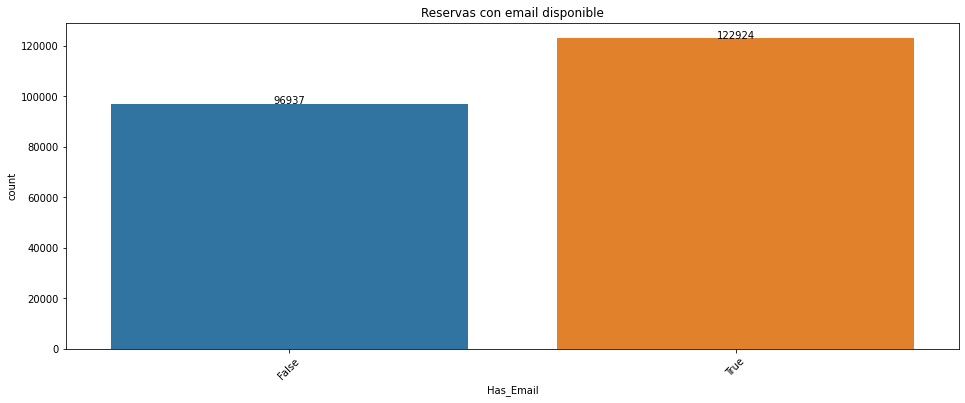

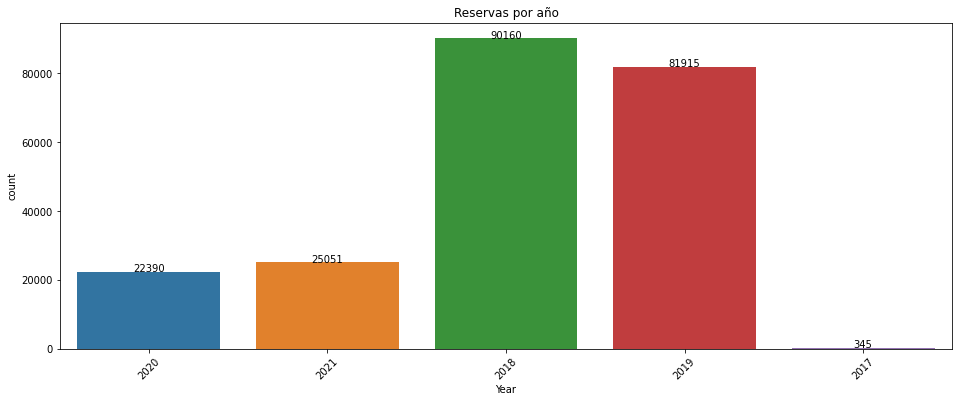

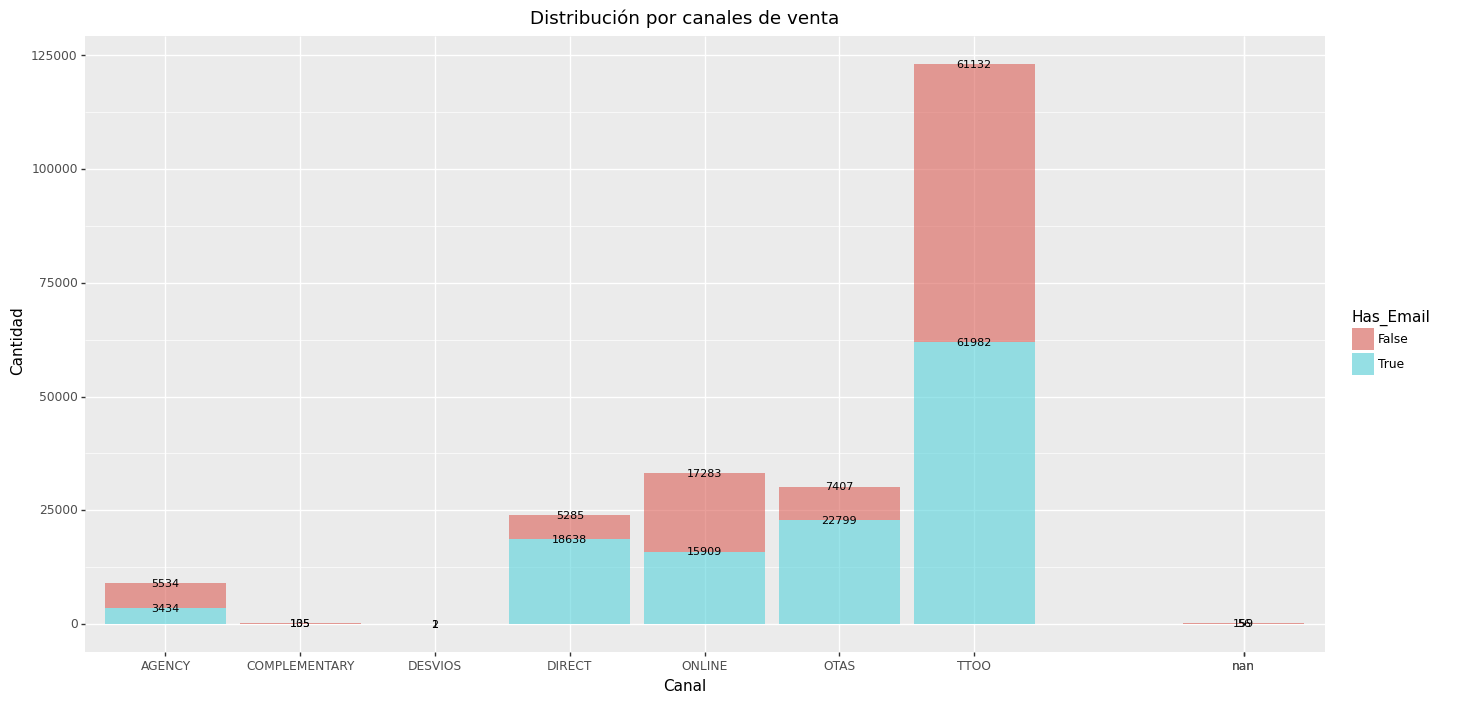

<ggplot: (8792936734693)>



Distribucion por países de los canales de venta






Tabla resumen por canal




posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


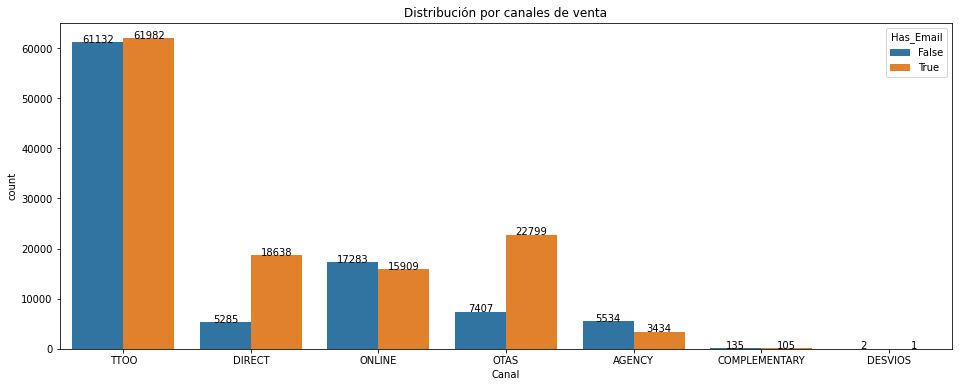

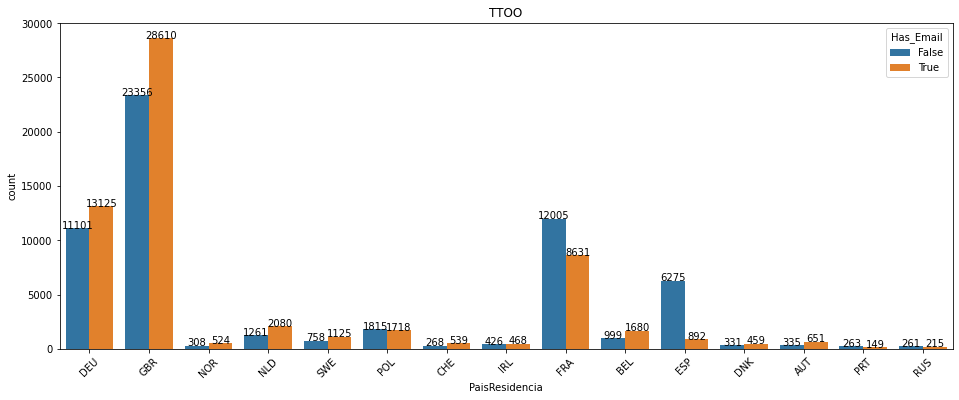

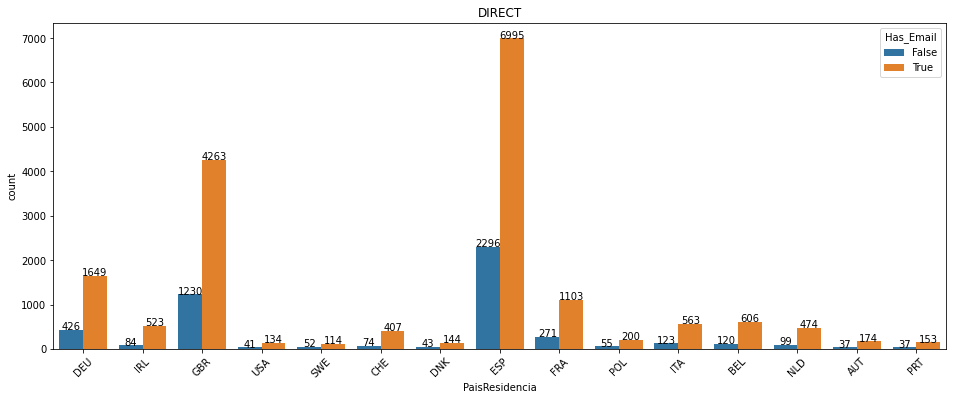

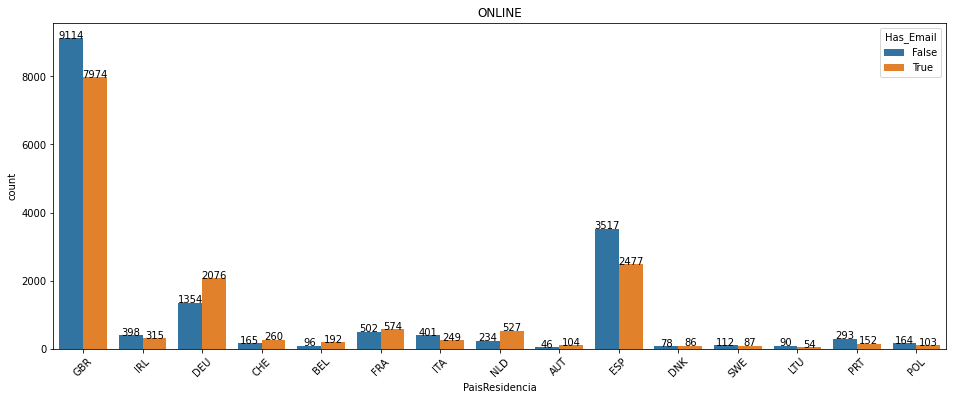

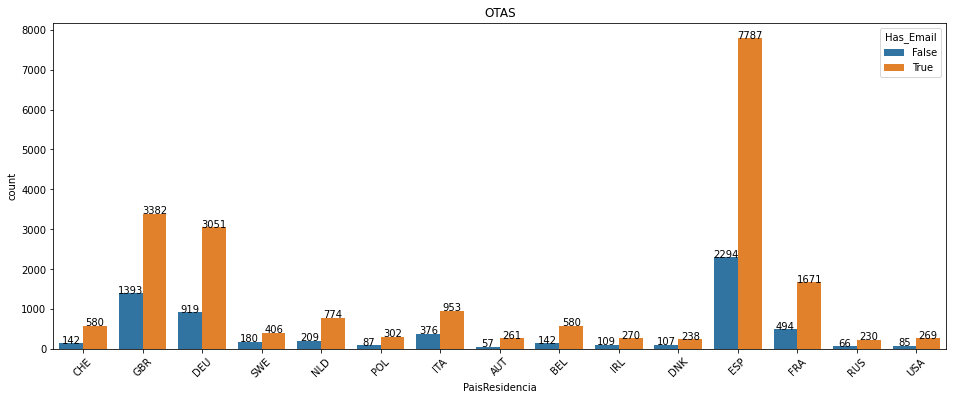

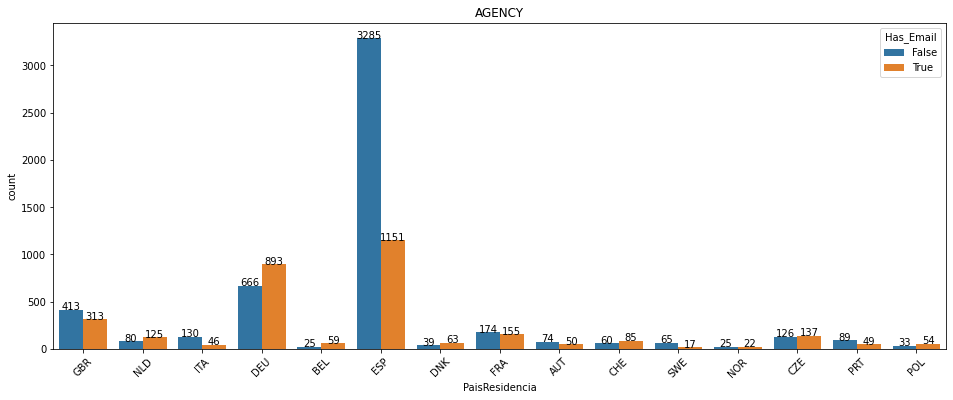

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


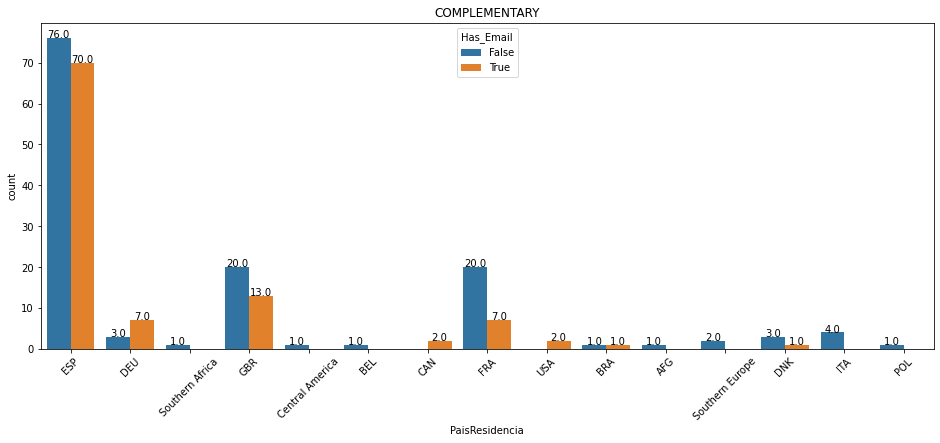

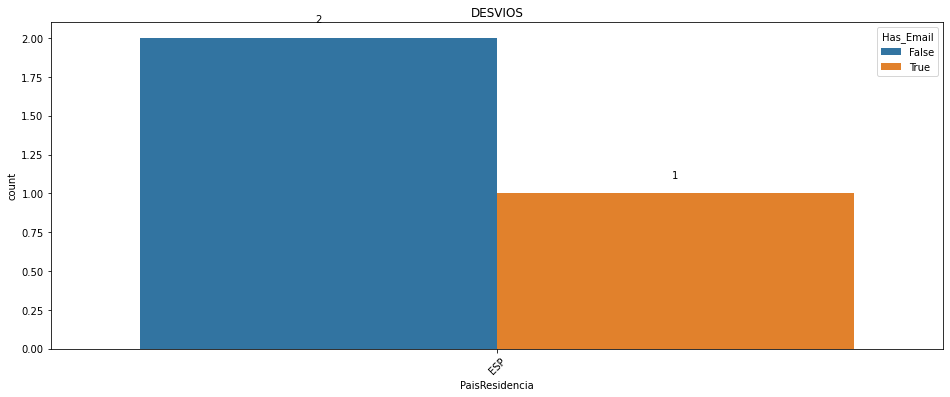

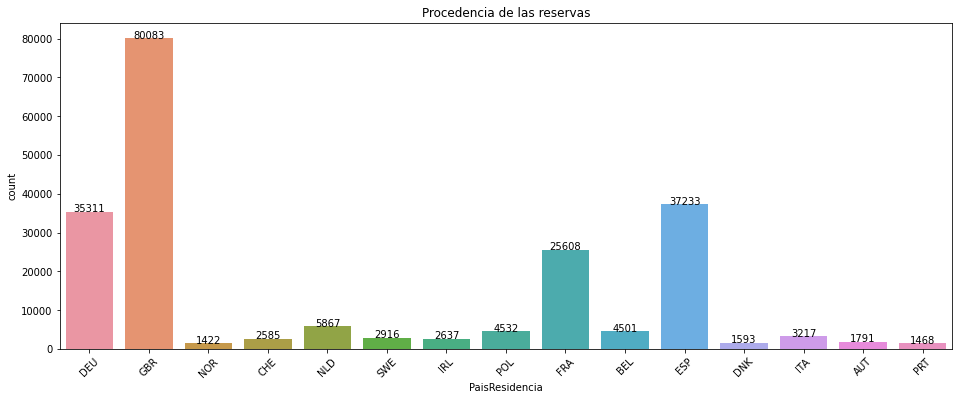

In [83]:
bookingVisualization(dfBookings)

In [85]:
dfBookings.to_csv('dataBookings' + '.csv')

In [ ]:
!cp data.csv "drive/My Drive/"